# CFM 101 Final Project

### Project Category: Market-Meet

### Group Member: Max Sun, Sean Lee, Rain Luo

#### Intial strategy:
In terms of overall strategy, we sought to replicate the market, matching the S&P 500 and TSX 60 sector composition. The simulated portfolio remains diversified by weighting stocks according to the sector’s actual market representation. For each sector, the algorithm identifies the stocks that have the highest correlation with the sector’s performance, selecting those stocks that move most similarly to the industry as they represent its behavior best. Once these stocks are identified, the strategy allocates more weight to the stocks that are most correlated with the sector, with the number of stocks selected based on the sector’s weight in the index. Specifically, for each industry, the top N stocks are chosen, where N is calculated as a percentage of the sector’s weight in the index, multiplied by 25. Additionally, the allocation progressively decreases for each subsequent stock in the industry. The strategy aims to backtest this portfolio construction to simulate potential profits by using historical data, allowing it to assess whether this sector-based selection method can outperform broader market indices. Essentially, the strategy seeks to leverage sector-specific performance to build a portfolio that could potentially beat the market.

## Design decisions 
1. We discovererd that for one particular stock, it can have a a high corrlation to mutiple sectors of the S&P. We have decided to put a maximium cap.
2. We decided to use a year worth of past trend. From discussing with other groups 

### Set up
1. We found out that there are tickers on yfinance that trackes the S&P by sectors, they are:

2. We also included the sectors composition in the S&P 500 and TSX 60, which we will use later on.

| Sector                 | Composition in S&P500 (%) | Composition in TSX60 (%) | S&P Ticker | TSX Ticker  |
|------------------------|----------------------|--------------------|-----------------|---------------|
| Basic Materials        | 1.71              | 8.49            | ^SP500-15       | ^GSPTTMT      |
| Industrials            | 7.19              | 13.11            | ^SP500-20       | ^GSPTTIN      |
| Consumer Cyclical      | 10.75              | 5.31            | ^SP500-25       | ^GSPTTCD      |
| Consumer Defensive     | 5.76              | 5.09            | ^SP500-30       | ^GSPTTCS      |
| Healthcare             | 10.14              | 0            | ^SP500-35       | ^GSPTTHC      |
| Financial Services     | 13.03              | 33.87            | ^SP500-40       | ^SPTTFS       |
| Technology             | 30.45              | 9.63            | ^SP500-45       | ^SPTTTK       |
| Communication Services | 13.40              | 3.04            | ^SP500-50       | ^GSPTTTS      |
| Utilities              | 2.35              | 3.18            | ^SP500-55       | ^GSPTTUT      |
| Real Estate            | 2.07              | 0.62            | ^SP500-60       | ^GSPTTRE      |
| Energy                 | 3.15              | 17.66            | ^SP500-1010     | ^SPTTEN       |


In [10]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import threading
import sys
import time

ATTRIBUTES = ['sector', 'exchange', 'currency', 'marketCap', 'previousClose']
START_DATE = '2023-10-01'
END_DATE = '2024-11-22'
END_DATE_VOL = '2024-10-01'
PCT_CAP = 0.07
MAX_STOCKS = 24
MIN_PCT = 1/(2*MAX_STOCKS)
MAX_PCT = 0.15
IDEAL_STOCKS = 17
PORTFOLIO_VALUE = 1e6
LAST_CALL = 0.0
WAIT_TIME = 1.0

# Each industry is mapped to (% share of S&P500, % share of TSX60, S&P industry ticker, TSX60 capped industry ticker)
# To obtain values for % share, run market_by_sector('SP500') and market_by_sector('TSX60'), respectively (see next cell)
# Since % share changes quarterly, we don't need to run this every time
SECTORS = {
    'Basic Materials': (0.0171, 0.0849, '^SP500-15', '^GSPTTMT'),
    'Industrials': (0.0719, 0.1311, '^SP500-20', '^GSPTTIN'),
    'Consumer Cyclical': (0.1075, 0.0531, '^SP500-25', '^GSPTTCD'),
    'Consumer Defensive': (0.0576, 0.0509, '^SP500-30', '^GSPTTCS'),
    'Healthcare': (0.1014, 0.0000, '^SP500-35', '^GSPTTHC'),
    'Financial Services': (0.1303, 0.3387, '^SP500-40', '^SPTTFS'),
    'Technology': (0.3045, 0.0963, '^SP500-45', '^SPTTTK'),
    'Communication Services': (0.1340, 0.0304, '^SP500-50', '^GSPTTTS'),
    'Utilities': (0.0235, 0.0318, '^SP500-55', '^GSPTTUT'),
    'Real Estate': (0.0207, 0.0062, '^SP500-60', '^GSPTTRE'),
    'Energy': (0.0315, 0.1766, '^SP500-1010', '^SPTTEN')
}

In [11]:
# adds market cap of ticker to data table
def ticker_by_sector(ticker, data):
    global LAST_CALL
    if(time.time() - LAST_CALL < WAIT_TIME):
        time.sleep(WAIT_TIME-(time.time()-LAST_CALL))
        LAST_CALL = time.time()
    yf_data = yf.Ticker(ticker).info
    data[yf_data['sector']] += yf_data['marketCap']

# prints percentage of index in each sector
def market_by_sector(index):
    tickers = pd.read_csv(index+'.csv', header=None)
    data = {sector: 0 for sector in SECTORS}
    threads = [threading.Thread(target=ticker_by_sector, args=(ticker,data)) for ticker in tickers[0]]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    sum = 0
    for sector in data:
        sum += data[sector]
    for sector in data:
        print(sector, 'accounts for', round(data[sector]/sum*100, 2), 'percent of', index)

### Fetch Data

Here is where we organized the data. We decided to filter out stocks that have less than 100,000 daily volume. 

In [12]:
# adds ticker info to data df
def get_data(ticker, data, history, filter):
    global LAST_CALL
    if(time.time() - LAST_CALL < WAIT_TIME):
        time.sleep(WAIT_TIME-(time.time()-LAST_CALL))
        LAST_CALL = time.time()
    yf_data = yf.Ticker(ticker).info
    if(not filter):
        for att in ATTRIBUTES:
            if(att not in yf_data):
                print(ticker, 'missing', att)
                continue
            data.loc[ticker, att] = yf_data[att]
        if(time.time() - LAST_CALL < WAIT_TIME):
            time.sleep(WAIT_TIME-(time.time()-LAST_CALL))
            LAST_CALL = time.time()
        hist = yf.Ticker(ticker).history(start=START_DATE, end=END_DATE)
        history[ticker] = hist['Close'].pct_change().dropna()
        return
    # check if stock is CAD or USD
    if('currency' not in yf_data or yf_data['currency'] not in ['USD', 'CAD']):
        data.drop(ticker, inplace=True)
        print('Dropped', ticker)
        return
    for att in ATTRIBUTES:
        if(att not in yf_data):
            print(ticker, 'missing', att)
            continue
        data.loc[ticker, att] = yf_data[att]
    if(time.time() - LAST_CALL < WAIT_TIME):
        time.sleep(WAIT_TIME-(time.time()-LAST_CALL))
        LAST_CALL = time.time()
    hist = yf.Ticker(ticker).history(start=START_DATE, end=END_DATE)
    history[ticker] = hist['Close'].pct_change().dropna()
    vol = yf.Ticker(ticker=ticker).history(start=START_DATE, end=END_DATE_VOL)
    volume = vol['Volume'].resample('MS').sum()
    # Take all months with >= 18 trading days for volume calculation
    volume.drop([month for month in volume.index if hist.resample('MS').size().loc[month] < 18], inplace=True)
    # check if stock has at least 100,000 average monthly volume
    if(volume.mean() < 1e5):
        data.drop(ticker, inplace=True)

# returns df containing all ticker info
def get_tickers(file_name='Tickers.csv', filter=True):
    with threading.Lock():
        tickers = pd.read_csv(file_name, header=None)
        data = pd.DataFrame(index=[ticker for ticker in tickers[0]], columns=ATTRIBUTES)
        history = {}
        threads = [threading.Thread(target=get_data, args=(ticker,data,history,filter)) for ticker in tickers[0]]
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()
    return (data, history)

In [13]:
def weighted_max_bipartite_matching(N, M, A, C):
    """
    Finds the weighted maximum bipartite matching for sectors and stocks.
    
    Args:
    - N: Number of sectors.
    - M: Number of stocks.
    - A: List of length N where A[i] is the number of stocks required by sector i.
    - C: 2D list (N x M) of weights (correlations) between sectors and stocks.
    
    Returns:
    - match: List of tuples (sector, stock) representing the matching.
    - total_weight: Total weight of the matching.
    """
    # Expand the graph: create dummy nodes for each sector demand
    total_sectors = sum(A)
    expanded_C = [[-sys.maxsize] * M for _ in range(total_sectors)]
    
    sector_mapping = []
    index = 0
    for i in range(N):
        for _ in range(A[i]):
            expanded_C[index] = C[i]
            sector_mapping.append(i)  # Map expanded sector to original sector
            index += 1

    # Hungarian algorithm for max-weight matching
    match = [-1] * M  # Stores which sector is assigned to each stock
    sector_label = [0] * total_sectors
    stock_label = [0] * M
    slack = [0] * M
    slack_x = [-1] * M
     
    def dfs(x, visited_x, visited_y):
        visited_x[x] = True
        for y in range(M):
            if visited_y[y]:
                continue
            delta = sector_label[x] + stock_label[y] - expanded_C[x][y]
            if delta == 0:  # Tight edge
                visited_y[y] = True
                if match[y] == -1 or dfs(match[y], visited_x, visited_y):
                    match[y] = x
                    return True
            else:  # Update slack
                if slack[y] > delta:
                    slack[y] = delta
                    slack_x[y] = x
        return False

    # Initialize labels
    for x in range(total_sectors):
        sector_label[x] = max(expanded_C[x])

    # Augmenting path search
    for x in range(total_sectors):
        slack = [sys.maxsize] * M
        slack_x = [-1] * M
        while True:
            visited_x = [False] * total_sectors
            visited_y = [False] * M
            if dfs(x, visited_x, visited_y):
                break
            # Update labels
            delta = min(slack[y] for y in range(M) if not visited_y[y])
            for i in range(total_sectors):
                if visited_x[i]:
                    sector_label[i] -= delta
            for y in range(M):
                if visited_y[y]:
                    stock_label[y] += delta
                else:
                    slack[y] -= delta

    # Extract results
    total_weight = 0
    final_match = []
    for y in range(M):
        if match[y] != -1:
            sector_idx = sector_mapping[match[y]]
            final_match.append((sector_idx, y))
            total_weight += C[sector_idx][y]

    return final_match

#### Performance & Correlation Analysis

Here, is the core of our algorithm. We decided to select stocks by their correlation to different sectors. First, we will be determining the correlation/ beta between the sectors and individual stock. From there, we will be selecting the stocks that have the most correlation with a specific sectors. In theory, a stock from technology can be selected to repersent the performance for other sectors other than tech. However, this is unlikely to happen, since the sectors indices only contains the stock of that specific sector. 

We have implemented functions to compute beta and correlation of each stock with each index. Throught testing, we decided to go with [insert method], as it does out-perform [insert other method]. This method provides a more direct measure of how closely the stock movements align with the sector's performance over time.

We start constructing the portfolio by calculating the correlation and beta for each stock relative to the sectors. These calculations identifies the stocks that will most accurately represent their respective sectors in the portfolio. Our goal is to maintain a balance between sectors while minimizing risk through diversification.

Next, we apply the max percentage rule to ensure that no single stock makes up more than 15% of the portfolio. Optimizing through binary search ensures we can find the optimal stock allocation, allowing us to include 24 stocks in the final portfolio while maintaining the diversification constraints. The create_portfolio function then selects stocks with the highest correlation to each sector, assigning each stock a weight based on the calculated correlations and the portfolio’s allocation rules. This maximum weight matching approach allows us to match stocks to sectors based on their correlation strength, making sure that stocks most aligned with a given sector are selected. This minimizes risk and diversifies the portfolio. 


In [14]:
# divide by 2 since each index is 50% of the "market"
def adjust_sector_cap():
    for sector in SECTORS:
        SECTORS[sector] = (SECTORS[sector][0]/2, SECTORS[sector][1]/2, SECTORS[sector][2], SECTORS[sector][3])

# binary search for optimal max percentage of a single stock such that we can have 24 stocks in our portfolio
def unit_percentage():
    low = MIN_PCT
    high = 1.0
    while(low < high):
        mid = (low+high)/2
        sum = 0
        for sector in SECTORS:
            sum += min(max(1, SECTORS[sector][0]//mid), SECTORS[sector][0]//MIN_PCT) + min(max(1, SECTORS[sector][1]//mid), SECTORS[sector][1]//MIN_PCT)
        if(sum > MAX_STOCKS):
            low = mid+0.0001
        else:
            high = mid-0.0001
    return low

# returns sector and index given a ticker from sectors dictionary
# 0 for S&P500, 1 for TSX60
def ticker_to_sector(ticker):
    for sector in SECTORS:
        if(ticker == SECTORS[sector][2]):
            return sector, 0
        if(ticker == SECTORS[sector][3]):
            return sector, 1
    return None

def beta(df, stock, sector):
    return df[stock].cov(df[sector])/df[sector].var()

def corr(df, stock, sector):
    return df[stock].corr(df[sector])

# returns function of stocks to sectors as given by f
# 0 for S&P500, 1 for TSX60
def calc(data, history, f, index):
    sector_metric = {stock:{} for stock in data.index}
    for sector in SECTORS:
        for stock in data.index:
            if(SECTORS[sector][index] == 0):
                continue
            df = pd.DataFrame({stock: history[stock], sector: history[SECTORS[sector][2+index]]}).dropna()
            # calculate metric given a function f
            sector_metric[stock][sector] = f(df, stock, sector)
    return sector_metric

# returns df containing history for each sector in TSX60
# since historical data for individual TSX60 sectors is unavailable, we take the weighted average of all stocks in each sector
def tsx_sectors():
    data, history = get_tickers('TSX60.csv', False)
    sector_history = pd.DataFrame({SECTORS[sector][3]: 0 for sector in SECTORS}, index=history[data.index[0]].index)
    total_market_cap = {SECTORS[sector][3]: 0 for sector in SECTORS}
    for stock in history:
        total_market_cap[SECTORS[data['sector'].loc[stock]][3]] += data['marketCap'].loc[stock]
    for stock in history:
        sector = SECTORS[data['sector'].loc[stock]][3]
        sector_history[sector] += history[stock]*data['marketCap'].loc[stock]/total_market_cap[sector]
    return sector_history

# returns df containing history for each sector in S&P500
def sp_sectors():
    history = {SECTORS[sector][2]: yf.Ticker(SECTORS[sector][2]).history(start=START_DATE, end=END_DATE)['Close'].pct_change().dropna() for sector in SECTORS}
    return pd.DataFrame(history, index=list(history.values())[0].index)

# creates the portfolio
def create_portfolio(data, sector_corr, unit_pct):
    portfolio = {stock: 0 for stock in data.index}
    # maps sector to index to be used in bipartite matching
    SECTOR_IDX = {}
    # maps index to sector to convert back after matching
    IDX_SECTOR = {}
    # maps stock to index to be used in bipartite matching
    STOCK_IDX = {}
    # maps index to stock to convert back after matching
    IDX_STOCK = {}
    idx = 0
    for sector in SECTORS:
        SECTOR_IDX[SECTORS[sector][2]] = idx # S&P500
        IDX_SECTOR[idx] = SECTORS[sector][2] # S&P500
        SECTOR_IDX[SECTORS[sector][3]] = idx+1 # TSX60
        IDX_SECTOR[idx+1] = SECTORS[sector][3] # TSX60
        idx += 2
    idx = 0
    for stock in data.index:
        for i in range(int(PCT_CAP/unit_pct)):
            STOCK_IDX[stock] = idx
            IDX_STOCK[idx] = stock
            idx += 1
    CORR = [[] for _ in SECTOR_IDX]
    NUM_STOCKS = [0 for _ in SECTOR_IDX]
    for sector in SECTORS:
        for i in range(2):
            if(SECTORS[sector][i] < MIN_PCT): # also checks if sector has no percentage
                continue
            for j in range(len(IDX_STOCK)):
                CORR[SECTOR_IDX[SECTORS[sector][2+i]]].append(int((1-abs(sector_corr[i][IDX_STOCK[j]][sector]-1))*1000)+10000) # weight of edge between sector and stock
            NUM_STOCKS[SECTOR_IDX[SECTORS[sector][2+i]]] = int(min(max(1, SECTORS[sector][i]//unit_pct), SECTORS[sector][i]//MIN_PCT)) # number of stocks required by sector
    result = weighted_max_bipartite_matching(len(SECTOR_IDX), len(IDX_STOCK), NUM_STOCKS, CORR)
    # adds stocks from matching to portfolio
    for pair in result:
        sector, idx = ticker_to_sector(IDX_SECTOR[pair[0]])
        portfolio[IDX_STOCK[pair[1]]] += unit_pct if SECTORS[sector][idx] >= unit_pct else SECTORS[sector][idx]
    # adds stocks best correlated with remaining sectors to portfolio and fills all sector quotas with highest correlated stocks
    for sector in SECTORS:
        for i in range(2):
            remaining = SECTORS[sector][i] - SECTORS[sector][i]//unit_pct*unit_pct
            if(remaining == 0 or (SECTORS[sector][i] >= MIN_PCT and SECTORS[sector][i] < unit_pct)):
                continue
            best_corr = sector_corr[i][IDX_STOCK[0]][sector]
            best_stock = IDX_STOCK[0]
            for j in range(len(IDX_STOCK)):
                if(portfolio[IDX_STOCK[j]] != 0 and sector_corr[i][IDX_STOCK[j]][sector] > best_corr and portfolio[IDX_STOCK[j]]+remaining <= MAX_PCT):
                    best_corr = sector_corr[i][IDX_STOCK[j]][sector]
                    best_stock = IDX_STOCK[j]
            portfolio[best_stock] += remaining
    sum = 0
    count = 0
    for stock in portfolio:
        portfolio[stock] = round(portfolio[stock], 4)
        sum += portfolio[stock]
        count += 1 if portfolio[stock] != 0 else 0
    for stock in portfolio:
        if(portfolio[stock] != 0):
            portfolio[stock] += round(1-sum, 4)
            sum = 1.0
            break
    return portfolio, sum, count

#### Driver Code

In [15]:
adjust_sector_cap()
data, history = get_tickers()
tsx_by_sector = tsx_sectors()
for sector in tsx_by_sector:
    history[sector] = tsx_by_sector[sector]
sp_by_sector = sp_sectors()
for sector in sp_by_sector:
    history[sector] = sp_by_sector[sector]
sector_corr = [calc(data, history, corr, 0), calc(data, history, corr, 1)]
stocks = 0
tot = 0
portfolio = {}
while(stocks < IDEAL_STOCKS):
    MAX_STOCKS += 1
    MIN_PCT = 1/(2*MAX_STOCKS)
    unit_pct = unit_percentage()
    portfolio, tot, stocks = create_portfolio(data, sector_corr, unit_pct)
portfolio

Dropped AGN
Dropped CELG
Dropped MON
Dropped RTN


{'AAPL': 0.0562,
 'ABBV': 0,
 'ABT': 0,
 'ACN': 0,
 'AIG': 0.0601,
 'AMZN': 0.0925,
 'AXP': 0,
 'BA': 0,
 'BAC': 0.0651,
 'BB.TO': 0,
 'BIIB': 0.0507,
 'BK': 0.0282,
 'BLK': 0.0502,
 'BMY': 0,
 'C': 0,
 'CAT': 0.0942,
 'CL': 0.0255,
 'KO': 0.0406,
 'LLY': 0,
 'LMT': 0,
 'MO': 0,
 'MRK': 0,
 'PEP': 0,
 'PFE': 0,
 'PG': 0,
 'PM': 0,
 'PYPL': 0,
 'QCOM': 0.0676,
 'RY.TO': 0.1249,
 'SHOP.TO': 0.0481,
 'T.TO': 0,
 'TD.TO': 0.0266,
 'TXN': 0.0565,
 'UNH': 0,
 'UNP': 0.0565,
 'UPS': 0,
 'USB': 0.0565}

#### Data Display

Here is where we organzie our data, and display the dataframe `Portfolio_Final`

In [16]:
stocks_to_buy = [stock for stock in portfolio if portfolio[stock] != 0]
Portfolio_Final = pd.DataFrame(index=[i+1 for i in range(len(stocks_to_buy))], columns=['Ticker', 'Price', 'Currency', 'Shares', 'Value', 'Weight'])
for stock in stocks_to_buy:
    idx = stocks_to_buy.index(stock)+1
    Portfolio_Final.loc[idx, 'Ticker'] = stock
    Portfolio_Final.loc[idx, 'Price'] = data['previousClose'].loc[stock]
    Portfolio_Final.loc[idx, 'Currency'] = data['currency'].loc[stock]
    Portfolio_Final.loc[idx, 'Shares'] = portfolio[stock]*PORTFOLIO_VALUE/Portfolio_Final['Price'].loc[idx]
    Portfolio_Final.loc[idx, 'Value'] = portfolio[stock]*PORTFOLIO_VALUE
    Portfolio_Final.loc[idx, 'Weight'] = portfolio[stock]
Portfolio_Final.loc['Total', 'Ticker'] = '--'
Portfolio_Final.loc['Total', 'Price'] = '--'
Portfolio_Final.loc['Total', 'Currency'] = '--'
Portfolio_Final.loc['Total', 'Shares'] = Portfolio_Final['Shares'].sum()
Portfolio_Final.loc['Total', 'Value'] = Portfolio_Final['Value'].sum()
Portfolio_Final.loc['Total', 'Weight'] = Portfolio_Final['Weight'].sum()
Portfolio_Final

,Ticker,Price,Currency,Shares,Value,Weight
1,AAPL,229.0,USD,245.414847,56200.0,0.0562
2,AIG,74.66,USD,804.982588,60100.0,0.0601
3,AMZN,202.88,USD,455.934543,92500.0,0.0925
4,BAC,46.06,USD,1413.37386,65100.0,0.0651
5,BIIB,156.0,USD,325.0,50700.0,0.0507
6,BK,77.87,USD,362.142032,28200.0,0.0282
7,BLK,1024.67,USD,48.991383,50200.0,0.0502
8,CAT,381.5,USD,246.920052,94200.0,0.0942
9,CL,93.91,USD,271.536578,25500.0,0.0255
10,KO,62.99,USD,644.546753,40600.0,0.0406


Date
2023-10-03 00:00:00-04:00    0.988622
2023-10-04 00:00:00-04:00    0.994250
2023-10-05 00:00:00-04:00    0.996432
2023-10-06 00:00:00-04:00    1.005120
2023-10-09 00:00:00-04:00         NaN
                               ...   
2024-11-15 00:00:00-05:00    1.414395
2024-11-18 00:00:00-05:00    1.418507
2024-11-19 00:00:00-05:00    1.421826
2024-11-20 00:00:00-05:00    1.422438
2024-11-21 00:00:00-05:00    1.435193
Length: 288, dtype: float64

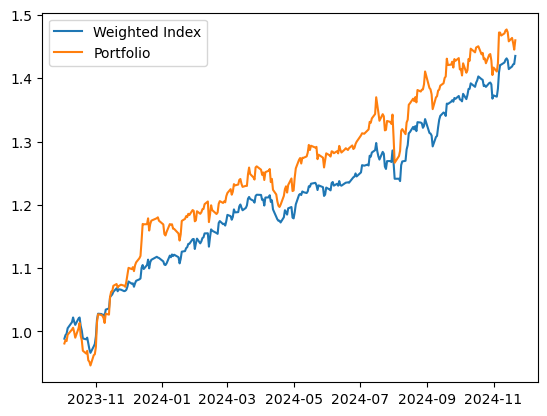

In [17]:
# returns sector percent change since start date
def aggregate_pct_change(history):
    result = pd.Series(index=history.index)
    prev = 1
    for day in history.index:
        if(pd.isna(history[day])):
            continue
        result[day] = prev*(1+history[day])
        prev = result[day]
    return result

historical_data = pd.Series(0, index=history[stocks_to_buy[0]].index)
for stock in stocks_to_buy:
    historical_data += portfolio[stock]*history[stock]
weighted_index = pd.Series(0, index=history[stocks_to_buy[0]].index)
for sector in SECTORS:
    for i in range(2):
        weighted_index += SECTORS[sector][i]*history[SECTORS[sector][2+i]]
plt.plot(aggregate_pct_change(weighted_index).dropna(), label='Weighted Index')
plt.plot(aggregate_pct_change(historical_data).dropna(), label='Portfolio')
plt.legend()
aggregate_pct_change(weighted_index)

#### Export to CSV File

In [18]:
Portfolio_Final.to_csv("Stocks_Group_10.csv")